In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid', font_scale = 1.5, color_codes=True)
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50)

### Load and merge all of the processed data

In [63]:
# Because historical transactions dataset is so large, we separated it into batches and 
# processed separately. So now we need to start by merging the batches into a single dataframe.
aux_df = None

for i in [0, 1, 2, 3, 4, 5]:
    new_df = pd.read_csv('/home/nikolaevra/datasets/elo/' + 'df_' + str(i) + '.csv', index_col='card_id')
    
    if i == 1:
        aux_df = new_df
    else:
        aux_df = pd.concat([aux_df, new_df], sort=False)

In [64]:
# Fill all rows that have nans with the man value for that column.
aux_df['std_days_between_purch'] = aux_df['std_days_between_purch'].fillna(aux_df['std_days_between_purch'].mean())
aux_df['std_purchase_amount'] = aux_df['std_purchase_amount'].fillna(aux_df['std_purchase_amount'].mean())
aux_df['std_numerical_1'] = aux_df['std_numerical_1'].fillna(aux_df['std_numerical_1'].mean())
aux_df['std_numerical_2'] = aux_df['std_numerical_2'].fillna(aux_df['std_numerical_2'].mean())

In [65]:
# Because preprocessing was done in batches, we have some repeat ids after
# merging batch dataframes together (i.e. when we split datasets for 
# batching some ids appeared in two splits)
aux_df = aux_df.drop(
    aux_df[
        (aux_df.index == 'C_ID_12d7f4104c') & 
        (aux_df['num_purchases'] == 10.0)
    ].index,
    axis=0
)
aux_df = aux_df.drop(
    aux_df[
        (aux_df.index == 'C_ID_85ff5e8b39') & 
        (aux_df['num_purchases'] == 13.0)
    ].index,
    axis=0
)
aux_df = aux_df.drop(
    aux_df[
        (aux_df.index == 'C_ID_97c510f051') & 
        (aux_df['num_purchases'] == 171.0)
    ].index,
    axis=0
)
aux_df = aux_df.drop(
    aux_df[
        (aux_df.index == 'C_ID_9822d11802') & 
        (aux_df['num_purchases'] == 31.0)
    ].index,
    axis=0
)

## Load training data

In [66]:
# Load the training dataset.
train_df = pd.read_csv('/home/nikolaevra/datasets/elo/train.csv', index_col='card_id')

In [67]:
# Join training dataset with auxilary preprocessed data.
# Since we want to keep same number of rows as in
# training set, we do a left join.
joined_df = train_df.join(
    aux_df,
    how='left',
    on='card_id'
)

# Shuffle the training dataset.
joined_df = joined_df.sample(frac=1)

# Create dummy variables for the feature columns provided 
# in the training dataset.
cat_cols = ['feature_1', 'feature_2', 'feature_3']
for cat in cat_cols:
    dummies = pd.get_dummies(joined_df[cat], prefix=cat)
    joined_df = pd.concat([joined_df, dummies], axis=1)

final_df = joined_df.reset_index(drop=True)

In [68]:
# Drop uneccessary columns.
final_df = final_df.drop(columns=['first_active_month'] + cat_cols)
final_df = final_df.replace(np.inf, 0)

# Drop all of the nan, inf, -inf values.
# final_df = final_df[~final_df.isin([np.isnan, np.inf, -np.inf]).any(1)]
# final_df[np.isnan(final_df).any(1)].shape

In [69]:
# Drop Nan rows because those are ids with no transactions all together. 
# Can't do anything about them and there are a too many of 
# them (~15,000) to fill rows with mean of each column. 
# Don't want to degrade the model.
final_df = final_df.dropna()

In [70]:
# Convert y values into a numpy array.
raw_Y = final_df['target'].values

# Convert X values into numpy array.
cols_to_use = final_df.columns.difference(['target', 'card_id'])
raw_X = final_df[cols_to_use].values

print("X:", raw_X.shape, "Y:", raw_Y.shape)

X: (186425, 80) Y: (186425,)


In [71]:
split_ratio = 0.996 # i.e. 90% for training and 10% for test.
split_point = int(split_ratio * raw_X.shape[0])

# Split into train and test sets.
print('Splitting at index:', split_point)
X_train = raw_X[:split_point, :]
y_train = raw_Y[:split_point]

X_test = raw_X[split_point:, :]
y_test = raw_Y[split_point:]

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Splitting at index: 185679
X_train (185679, 80)
y_train (185679,)
X_test (746, 80)
y_test (746,)


## Building the GBT

In [72]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [73]:
# Fit regression model
params = {
    'n_estimators': 50,
    'max_depth': 4,
    'min_samples_split': 10,
    'learning_rate': 0.1,
    'loss': 'ls'
}
# increase learning rate to 0.1
# Find optimum number of trees for this lr
# Increase number of samples for split

clf = ensemble.GradientBoostingRegressor(**params)
model = clf.fit(X_train, y_train)

mse_train = mean_squared_error(y_train, clf.predict(X_train))
mse_test = mean_squared_error(y_test, clf.predict(X_test))

print("==================================")
print("Train RMSE: %.4f" % np.sqrt(mse_train))
print("Test RMSE: %.4f" % np.sqrt(mse_test))

Train RMSE: 3.8168
Test RMSE: 3.8049


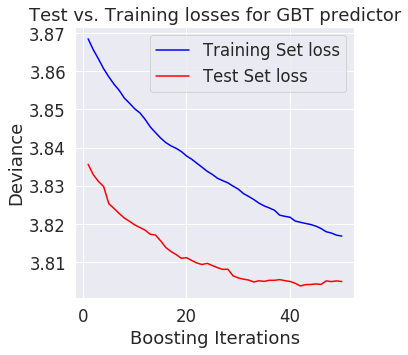

In [74]:
# Compute test score
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

# Plot training vs. test loss
plt.figure(figsize=(5, 5))
plt.title('Test vs. Training losses for GBT predictor')
plt.plot(np.arange(params['n_estimators']) + 1, np.sqrt(clf.train_score_), 'b-',
         label='Training Set loss')
plt.plot(np.arange(params['n_estimators']) + 1, np.sqrt(test_score), 'r-',
         label='Test Set loss')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.savefig('train_test_loss_gbt.png')
plt.show()

In [75]:
final_df[cols_to_use].columns

Index(['authorized_unauthorized_ratio', 'avg_active_months_lag12',
       'avg_days_between_purch', 'avg_installments', 'avg_month_lag',
       'avg_numerical_1', 'avg_numerical_2', 'avg_purchase_amount',
       'avg_purchases_lag12', 'category_1_N', 'category_1_Y',
       'category_2_-1.0', 'category_2_1.0', 'category_2_2.0', 'category_2_3.0',
       'category_2_4.0', 'category_2_5.0', 'category_3_-1', 'category_3_A',
       'category_3_B', 'category_3_C', 'category_4_N', 'category_4_Y',
       'feature_1_1', 'feature_1_2', 'feature_1_3', 'feature_1_4',
       'feature_1_5', 'feature_2_1', 'feature_2_2', 'feature_2_3',
       'feature_3_0', 'feature_3_1', 'max_numerical_1', 'max_numerical_2',
       'max_purchase_amount', 'min_numerical_1', 'min_numerical_2',
       'min_purchase_amount', 'most_recent_purchases_range_A',
       'most_recent_purchases_range_B', 'most_recent_purchases_range_C',
       'most_recent_purchases_range_D', 'most_recent_purchases_range_E',
       'most_recent_

In [76]:
# Plot feature importance
feature_importance = clf.feature_importances_

In [77]:
# Normalize feature importances so that they dont 
# just out of the graph.
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

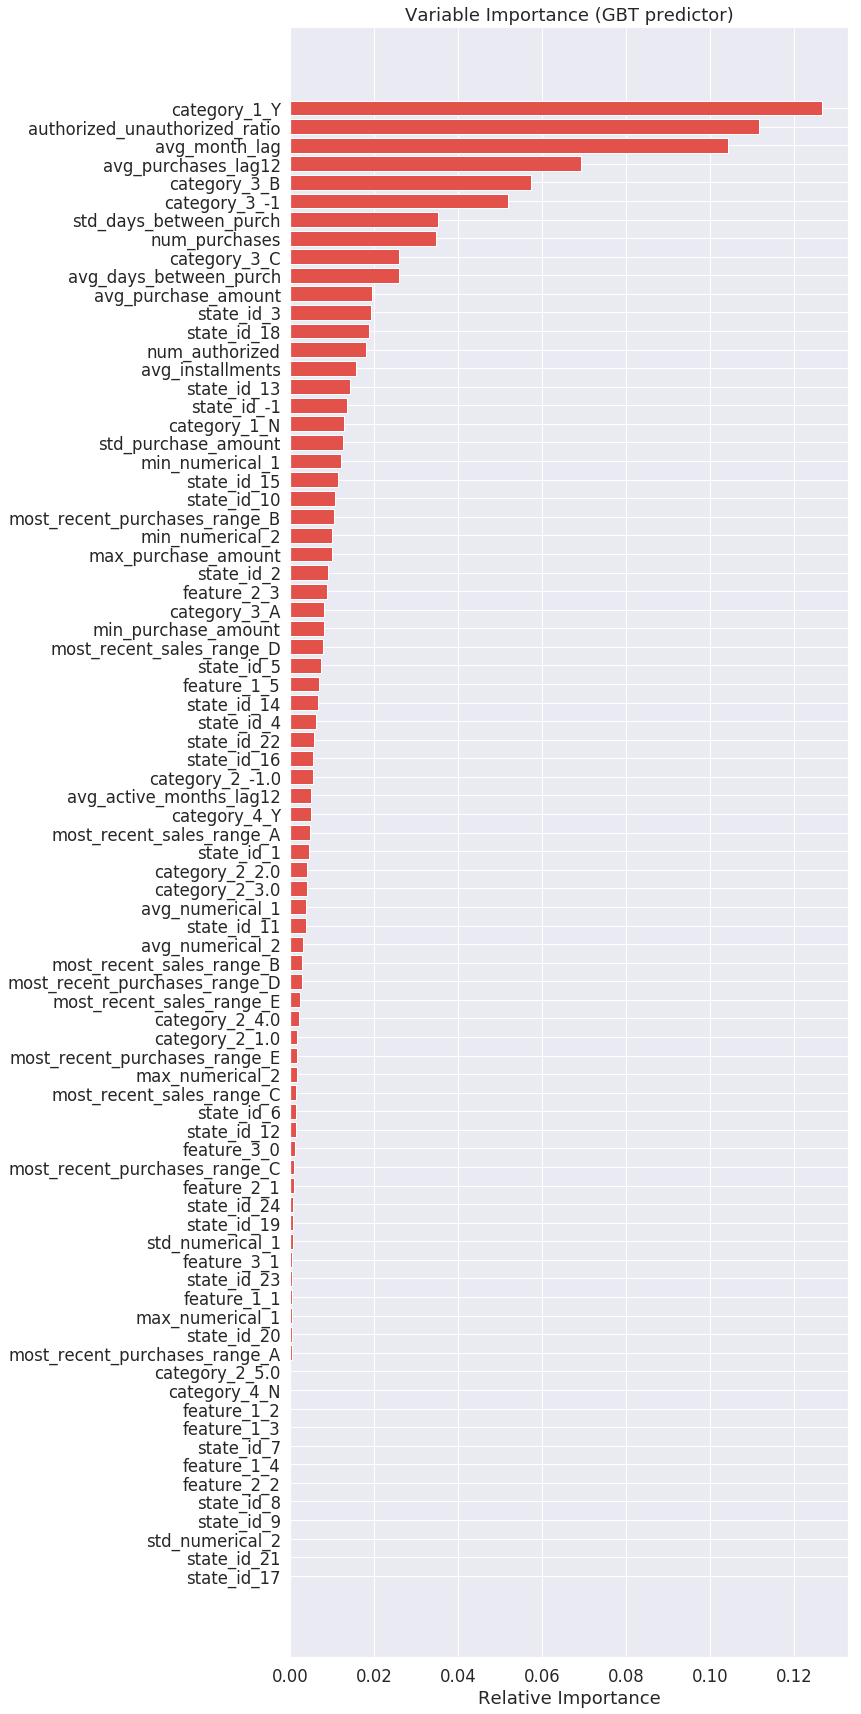

In [78]:
plt.figure(figsize=(10, 30))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, final_df[cols_to_use].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (GBT predictor)')
plt.savefig('variable_importance_gbt.png')
plt.show()

In [79]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn import tree
import pydotplus
from IPython.display import Image  
import matplotlib.pyplot as plt

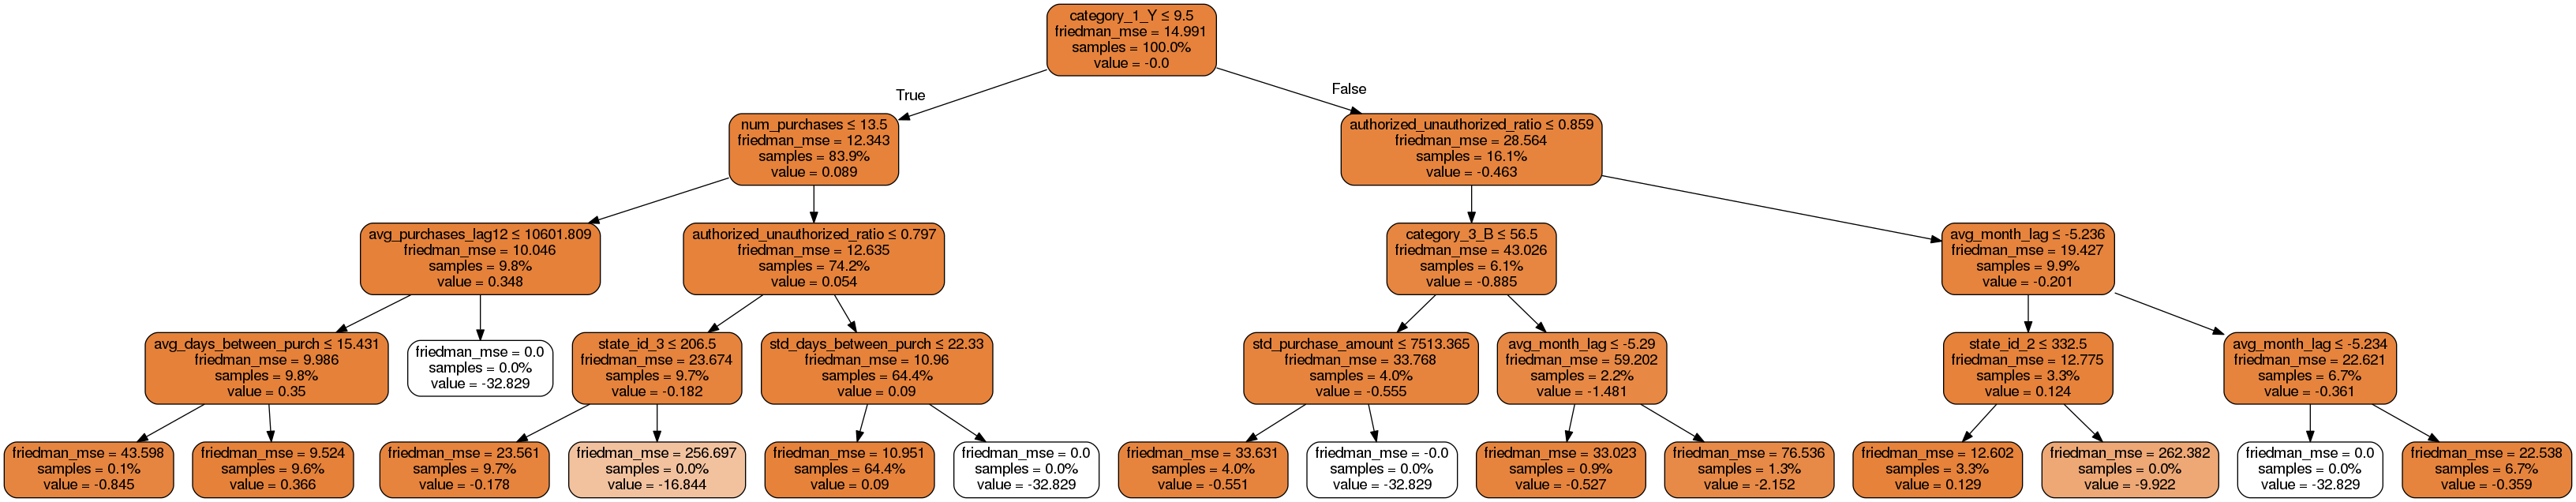

In [80]:
# Get the tree number 42
sub_tree_42 = clf.estimators_[0, 0]

dot_data = tree.export_graphviz(
    sub_tree_42,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True,
    feature_names=final_df[cols_to_use].columns
)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

In [81]:
graph.write_png("decision_tree_GBT.png")

True

## Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(raw_X, raw_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [83]:
mse_train = mean_squared_error(y_train, lm.predict(X_train))
mse_test = mean_squared_error(y_test, lm.predict(X_test))

print("==================================")
print("Train RMSE: %.4f" % np.sqrt(mse_train))
print("Test RMSE: %.4f" % np.sqrt(mse_test))

Train RMSE: 3.8577
Test RMSE: 3.8300


## NN

In [84]:
from keras import backend as K
from keras import models
from keras import layers
from keras import regularizers

import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

# Build neural network
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1], )))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2592      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [85]:
# RMSE is the preferred metric in the competition, so
# we are going to use it as well.
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

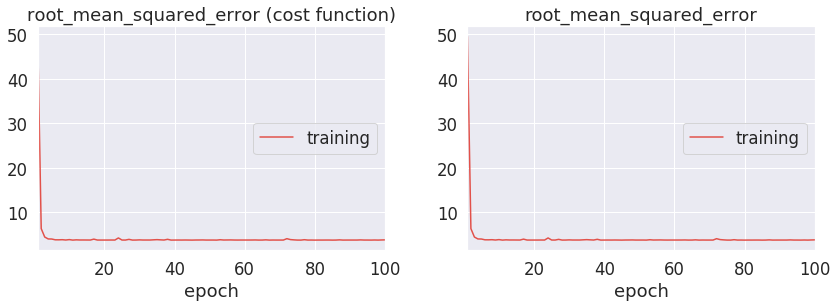

root_mean_squared_error (cost function):
training   (min:    3.743, max:   49.509, cur:    3.800)

root_mean_squared_error:
training   (min:    3.743, max:   49.509, cur:    3.800)


In [86]:
# Compile model
model.compile(
    optimizer='rmsprop',
    loss=root_mean_squared_error,
    metrics=[root_mean_squared_error]
)

# Train model. Use stochastic gradient descent because it converges 
# better comapred to sinle example iterations.
history = model.fit(
    raw_X,
    raw_Y,
    batch_size=256,
    epochs=100,
    verbose=1,
    callbacks=[plot_losses]
)

## Import test data

In [87]:
# Import test dataset.
test_df = pd.read_csv('/home/nikolaevra/datasets/elo/test.csv', index_col='card_id')

In [88]:
# Join test and auxilary datasets.
joined_test_df = test_df.join(
    aux_df,
    how='left',
    on='card_id'
)

# Convert categorical columns into dummy variables.
cat_cols = ['feature_1', 'feature_2', 'feature_3']
for cat in cat_cols:
    dummies = pd.get_dummies(joined_test_df[cat], prefix=cat)
    joined_test_df = pd.concat([joined_test_df, dummies], axis=1)

In [89]:
final_test_df = joined_test_df.reset_index()
final_test_df = final_test_df.replace(np.inf, 0)
final_test_df = final_test_df[cols_to_use]

# Some rows still have missng data, but there is ~7000 of
# them, so going to replace with mean value for the column instead
# of deleting because when submitting to kaggle, we need to have
# same number of rows as in provided test set (i.e. can't drop any rows)
for k, v in final_test_df.isna().any().to_dict().items():
    if v:
        final_test_df[k] = final_test_df[k].fillna(final_test_df[k].mean())

In [90]:
# Convert dataframe into numpy array.
raw_test_X = final_test_df[cols_to_use].values

# Make predictions for test set.
predictions = clf.predict(raw_test_X)

# Write predictions into a csv file.
output = test_df
output['target'] = predictions
output[['target']].to_csv('answer.csv', sep=',')

# 